# General Index Data Framework
General index data input using a test dataset of ~750 manuscripts
across 2 topics: Antediluvian and Hennig86. 

---
Created 6/3/22 by Ian Hay   
Updated 7/23/22

### Imports
Dependencies

---
[Python 3.8+](https://www.python.org/downloads/release/python-380/)    
[Pandas](https://pandas.pydata.org/)   
[NumPy](https://numpy.org/)    
[scikit-learn](https://scikit-learn.org/stable/index.html)  
[nltk](https://www.nltk.org/)   
[spacy](https://pypi.org/project/spacy/)    
[matplotlib](https://matplotlib.org/)   

In [1]:
"""
Run this line in your python environment before running the code below:

conda install -c anaconda numpy scipy pandas nltk ssl spacy matplotlib scikit-learn

"""
import pandas as pd
import numpy as np
import nltk
import ssl
import spacy
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
"""
Run this line in your python environment before running the code below: 

python -m spacy download en_core_web_sm

"""
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ianha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions

In [3]:
# Data Processing -------------------------------------------------------------------------------------------

def getDocColumn(df, column, newColumnName):
    """
    Given a dataframe and a column of datatype list, constructs
    a new column newColumnName with the list joined into a single
    string and items separated by spaces (" ").
    """
    strDict = {}
    for row in range(len(df)):
        text = ". ".join(df.iloc[row][column])
        text = text + "."
        strDict[df.index[row]] = text
    dfStr = pd.Series(strDict, name=newColumnName)
    df[newColumnName] = dfStr

def getBagOfWordsDF(df, docColumn):
    """
    Uses SKLearn's CountVectorizer to build a Bag-of-Words DataFrame
    for the given column. The column datatype should be formatted as 
    a document, where each document is a single string object.
    """
    countvec = CountVectorizer()
    X = countvec.fit_transform(df[docColumn])
    dfBOW = pd.DataFrame(X.toarray(),columns=countvec.get_feature_names_out())
    dfBOW.set_index(df.index, inplace=True)
    return dfBOW

def partOfSpeechTagging(texts, POS=["NOUN", "ADJ", "ADV", "VERB"]):
    """
    Utilizes Spacy to extract nouns and verbs from ngrams
    and build a new column with only these terms.
    https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel
    """
    textTagged = []
    for text in texts:
        doc = nlp(text)
        text_ = [token.lemma_ for token in doc if token.pos_ in POS]
        textTagged.append(" ".join(text_))
    return textTagged

def removeStopWords(texts):
    """
    Takes in texts (words in a single string separated by spaces).
    https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
    """
    textParsed = []
    from nltk.corpus import stopwords
    _stopWords = stopwords.words("english")
    _stopWords.extend(["-pron-", "pron"]) # these words appears in many ngrams without apparent meaning
    textParsed = texts.apply(lambda x: " ".join([word for word in x.split() if word not in (list(_stopWords))]))
    return textParsed

In [4]:
# Utility --------------------------------------------------------------------------------------------------

def loadTextFileIntoDataframe(filepath, columns, splittingChar="\t"):
    """
    Opens the given filepath into a pandas dataframe.
    Splits the list by the denoted character, by default tab.
    Returns a pandas dataframe.
    """
    with open(filepath) as file:
        data = file.readlines()
    df = pd.DataFrame(columns=columns)
    for line in data:
        lineSplit = [line.split(splittingChar)]
        if len(lineSplit[0]) < len(columns):
            for x in range(len(columns) - len(lineSplit[0])):
                lineSplit[0].append("0")
        lineDF = pd.DataFrame(lineSplit, columns=columns)
        df = pd.concat([df, lineDF], axis=0, ignore_index=True)
    return df

def standardizeDataColumn(df, column, newColumnName):
    """
    Standardizes the column of the dataframe df.
    Adds the new column newColumnName to the dataframe inplace.
    Mean is 0, variance is 1
    """
    data = df[column]
    mean = np.mean(data)
    std = np.std(data)
    zScore = []
    for x in range(len(df.index)):
        zScore.append((data[x] - mean) / std)
    df[newColumnName] = zScore


### Building Dataframe and Processing Data

In [5]:
# hard coded things
columnListNGrams = ["hash", "ngram", "ngram_lc", "ngram_tokens", "ngram_count", "term_freq", "doc_count", "date_added"]
columnListKeywords = ["hash", "keywords", "keywords_lc", "keyword_tokens", "keyword_score", "doc_count", "insert_date"]

non_words = ["a", "at", "an", "am", "and", "that", "like", "for", "by", "i", "in", "of", "or", "be", "use", "as", "on", "the", "to", "with", "-pron-"]

filenameAnteNGrams = "data/doc_ngrams/sample.fgrep.antediluvian.txt"
filepathHennigNGrams = "data/doc_ngrams/sample.fgrep.Hennig86.txt"
filenameAnteKeywords = "data/doc_keywords/sample.fgrep.antediluvian.txt"

In [6]:
# load test files into dataframe (may take up to 1 minute)

indexCol = columnListNGrams[0]
df_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnteNGrams, columns=columnListNGrams)
df_hennig = loadTextFileIntoDataframe(filepath=filepathHennigNGrams, columns=columnListNGrams)
df_antedivulian["topic"] = "antediluvian"
df_hennig["topic"] = "hennig86"
df = pd.concat([df_antedivulian, df_hennig])

# save the data for later use
df.to_csv("test_data.csv")

# process data columns
df["ngram_lc_tagged"] = partOfSpeechTagging(df["ngram_lc"])
df["ngram_lc_tagged"] = removeStopWords(df["ngram_lc_tagged"])
df = df.groupby(indexCol).agg(list)

yakeScoreCol = columnListNGrams[5]
for n in range(len(df)):
    term_freq_list = df[yakeScoreCol].iloc[n]
    df[yakeScoreCol].iloc[n] = term_freq_list[0]
    df["topic"].iloc[n] = df["topic"].iloc[n][0]
    if (len(df["ngram_lc_tagged"].iloc[n])) == 0: # if there are no noun/verb phrases from spacy preprocessing
        df["ngram_lc_tagged"][n] = df["ngram_lc"].iloc[n] # replace it with the lowercase ngram(s)
df[yakeScoreCol] = df[yakeScoreCol].astype(float)

standardizeDataColumn(df, yakeScoreCol, "standardized_term_freq")
getDocColumn(df, "ngram_lc_tagged", "ngram_lc_tagged_doc")
getDocColumn(df, "ngram_lc", "ngram_lc_doc")
df["topic_num"] = (df["topic"] == "antediluvian").astype(int)

# save the dataframe for later use
df.to_csv("test_data_processed.csv")

df.head()

,ngram,ngram_lc,ngram_tokens,ngram_count,term_freq,doc_count,date_added,topic,ngram_lc_tagged,standardized_term_freq,ngram_lc_tagged_doc,ngram_lc_doc,topic_num
hash,,,,,,,,,,,,,
3002e8a37ec9d00a67bdf0004b8628c35d72068d,"[antediluvian, antediluvian humanity]","[antediluvian, antediluvian humanity]","[1, 2]","[1, 1]",0.000010,"[1, 1]","[\N\n, \N\n]",antediluvian,"[antediluvian, antediluvian humanity]",-0.654965,antediluvian. antediluvian humanity.,antediluvian. antediluvian humanity.,1
3005b3bf055ddcb3c25e4742a72ee16728934efd,"[antediluvian, antediluvian refrain, follow by...","[antediluvian, antediluvian refrain, follow by...","[1, 2, 4, 5]","[1, 1, 1, 1]",0.000281,"[1, 1, 1, 1]","[\N\n, \N\n, \N\n, \N\n]",antediluvian,"[antediluvian, refrain, follow antediluvian, f...",-0.004052,antediluvian. refrain. follow antediluvian. fo...,antediluvian. antediluvian refrain. follow by ...,1
3005ebfe5508340797dbfcce8454f3d3f6f76eb1,"[antediluvian, antediluvian dream, cave of -PR...","[antediluvian, antediluvian dream, cave of -pr...","[1, 2, 4, 5, 5]","[1, 1, 1, 1, 1]",0.000091,"[1, 1, 1, 1, 1]","[2021-09-03\n, 2021-09-03\n, 2021-09-03\n, 202...",antediluvian,"[antediluvian, antediluvian dream, antediluvia...",-0.459385,antediluvian. antediluvian dream. antediluvian...,antediluvian. antediluvian dream. cave of -pro...,1
30064ae161de1e9a96992be108c195796f13e72a,"[Hennig86 program, routine in the Hennig86, ro...","[hennig86 program, routine in the hennig86, ro...","[2, 4, 5, 1]","[1, 1, 1, 1]",0.000198,"[1, 1, 1, 1]","[\N\n, \N\n, \N\n, \N\n]",hennig86,"[program, routine hennig86, routine hennig86 p...",-0.202622,program. routine hennig86. routine hennig86 pr...,hennig86 program. routine in the hennig86. rou...,0
30136ab3788ab8e8be6b939901ec669a41ef896a,[antediluvian],[antediluvian],[1],[1],0.000051,[1],[\N\n],antediluvian,[antediluvian],-0.556359,antediluvian.,antediluvian.,1


In [15]:
# read the processed data CSV
df = pd.read_csv("test_data_processed.csv")
df.set_index("hash", inplace=True)
df.head()

,ngram,ngram_lc,ngram_tokens,ngram_count,term_freq,doc_count,date_added,topic,ngram_lc_tagged,standardized_term_freq,ngram_lc_tagged_doc,ngram_lc_doc,topic_num
hash,,,,,,,,,,,,,
3002e8a37ec9d00a67bdf0004b8628c35d72068d,"['antediluvian', 'antediluvian humanity']","['antediluvian', 'antediluvian humanity']","['1', '2']","['1', '1']",0.000010,"['1', '1']","['\\N\n', '\\N\n']",antediluvian,"['antediluvian', 'antediluvian humanity']",-0.654965,antediluvian. antediluvian humanity.,antediluvian. antediluvian humanity.,1
3005b3bf055ddcb3c25e4742a72ee16728934efd,"['antediluvian', 'antediluvian refrain', 'foll...","['antediluvian', 'antediluvian refrain', 'foll...","['1', '2', '4', '5']","['1', '1', '1', '1']",0.000281,"['1', '1', '1', '1']","['\\N\n', '\\N\n', '\\N\n', '\\N\n']",antediluvian,"['antediluvian', 'antediluvian refrain', 'foll...",-0.004052,antediluvian. antediluvian refrain. follow ant...,antediluvian. antediluvian refrain. follow by ...,1
3005ebfe5508340797dbfcce8454f3d3f6f76eb1,"['antediluvian', 'antediluvian dream', 'cave o...","['antediluvian', 'antediluvian dream', 'cave o...","['1', '2', '4', '5', '5']","['1', '1', '1', '1', '1']",0.000091,"['1', '1', '1', '1', '1']","['2021-09-03\n', '2021-09-03\n', '2021-09-03\n...",antediluvian,"['antediluvian', 'antediluvian dream', 'cave a...",-0.459385,antediluvian. antediluvian dream. cave antedil...,antediluvian. antediluvian dream. cave of -pro...,1
30064ae161de1e9a96992be108c195796f13e72a,"['Hennig86 program', 'routine in the Hennig86'...","['hennig86 program', 'routine in the hennig86'...","['2', '4', '5', '1']","['1', '1', '1', '1']",0.000198,"['1', '1', '1', '1']","['\\N\n', '\\N\n', '\\N\n', '\\N\n']",hennig86,"['hennig86 program', 'routine hennig86', 'rout...",-0.202622,hennig86 program. routine hennig86. routine he...,hennig86 program. routine in the hennig86. rou...,0
30136ab3788ab8e8be6b939901ec669a41ef896a,['antediluvian'],['antediluvian'],['1'],['1'],0.000051,['1'],['\\N\n'],antediluvian,['antediluvian'],-0.556359,antediluvian.,antediluvian.,1


In [7]:
# creates a list of all words that appear in the dataset

from itertools import chain
masterTermList = []
for eachList in df["ngram_lc"].values:
    splitList = []
    for string in eachList:
        splitList.append(string.split(" "))
    masterTermList.append(splitList)
firstNest = list(chain(*masterTermList))
secondNest = list(chain(*firstNest))
masterTerms = list(dict.fromkeys(secondNest))

In [8]:
# count number of times each word appears in an ngram
dfBoW = getBagOfWordsDF(df, "ngram_lc_doc")
dfBoWTag = getBagOfWordsDF(df, "ngram_lc_tagged_doc")
wordCountDict = {}
wordCountDictTag = {}
for column in dfBoW.columns:
    wordCountDict[column] = np.sum(dfBoW[column])
for column in dfBoWTag.columns:
    wordCountDictTag[column] = np.sum(dfBoWTag[column])

### Data Visualization
https://medium.com/plotly/nlp-visualisations-for-clear-immediate-insights-into-text-data-and-outputs-9ebfab168d5b

In [90]:

fig = px.bar(df["ngram_lc"], y='count', title='Counts of top bigrams', template='plotly_white', labels={'ngram': 'Bigram', 'count': 'Count'})
fig.show()

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['ngram_lc'] but received: ngram

(array([471., 143.,  56.,  47.,  16.,   9.,   7.,   6.,   3.,   1.,   1.,
          3.,   0.,   1.,   0.,   0.,   0.,   3.,   1.]),
 array([5.09232383e-06, 2.06477866e-04, 4.07863408e-04, 6.09248950e-04,
        8.10634492e-04, 1.01202003e-03, 1.21340558e-03, 1.41479112e-03,
        1.61617666e-03, 1.81756220e-03, 2.01894775e-03, 2.22033329e-03,
        2.42171883e-03, 2.62310437e-03, 2.82448991e-03, 3.02587546e-03,
        3.22726100e-03, 3.42864654e-03, 3.63003208e-03, 3.83141762e-03]),
 <BarContainer object of 19 artists>)

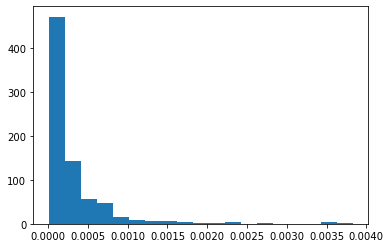

In [46]:
# histogram of term frequency
plt.hist(df["term_freq"], bins= "rice")

(array([533., 188.,  23.,   8.,   3.,   2.,   2.,   0.,   2.,   5.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 1.        ,  5.52631579, 10.05263158, 14.57894737, 19.10526316,
        23.63157895, 28.15789474, 32.68421053, 37.21052632, 41.73684211,
        46.26315789, 50.78947368, 55.31578947, 59.84210526, 64.36842105,
        68.89473684, 73.42105263, 77.94736842, 82.47368421, 87.        ]),
 <BarContainer object of 19 artists>)

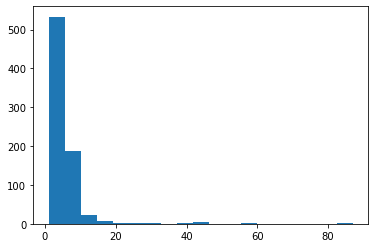

In [47]:
# histogram of number of ngrams per document
lenArr = []
for x in range(len(df.index)):
    lenArr.append(len(df["ngram_lc_tagged"][x]))
plt.hist(lenArr, bins= "rice")

(array([1.562e+03, 4.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.00000000e+00, 1.59952381e+02, 3.18904762e+02, 4.77857143e+02,
        6.36809524e+02, 7.95761905e+02, 9.54714286e+02, 1.11366667e+03,
        1.27261905e+03, 1.43157143e+03, 1.59052381e+03, 1.74947619e+03,
        1.90842857e+03, 2.06738095e+03, 2.22633333e+03, 2.38528571e+03,
        2.54423810e+03, 2.70319048e+03, 2.86214286e+03, 3.02109524e+03,
        3.18004762e+03, 3.33900000e+03]),
 <BarContainer object of 21 artists>)

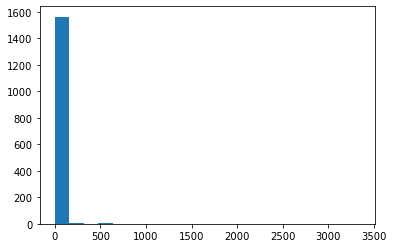

In [52]:
plt.hist(wordCountDict.values(), bins="doane")

(array([1.34e+03, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00]),
 array([1.00000000e+00, 1.60714286e+02, 3.20428571e+02, 4.80142857e+02,
        6.39857143e+02, 7.99571429e+02, 9.59285714e+02, 1.11900000e+03,
        1.27871429e+03, 1.43842857e+03, 1.59814286e+03, 1.75785714e+03,
        1.91757143e+03, 2.07728571e+03, 2.23700000e+03, 2.39671429e+03,
        2.55642857e+03, 2.71614286e+03, 2.87585714e+03, 3.03557143e+03,
        3.19528571e+03, 3.35500000e+03]),
 <BarContainer object of 21 artists>)

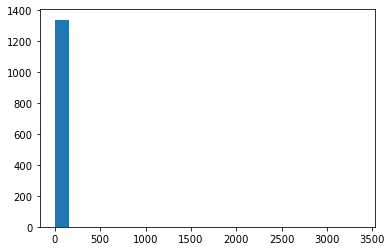

In [82]:
plt.hist(wordCountDictTag.values(), bins="doane")

(array([1.201e+03, 7.200e+01, 3.500e+01, 1.000e+01, 4.000e+00, 5.000e+00,
        5.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00]),
 array([  1.        ,   6.36842105,  11.73684211,  17.10526316,
         22.47368421,  27.84210526,  33.21052632,  38.57894737,
         43.94736842,  49.31578947,  54.68421053,  60.05263158,
         65.42105263,  70.78947368,  76.15789474,  81.52631579,
         86.89473684,  92.26315789,  97.63157895, 103.        ]),
 <BarContainer object of 19 artists>)

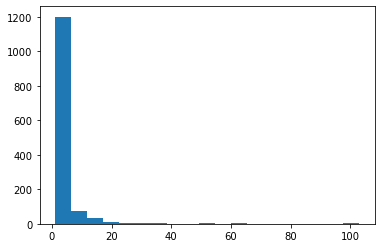

In [87]:
wordCountDictTagDropped = wordCountDictTag.copy()
wordCountDictTagDropped.pop("antediluvian")
wordCountDictTagDropped.pop("hennig86")
wordCountDictTagDropped.pop("the")

plt.hist(wordCountDictTagDropped.values(), bins="doane")